In [1]:
import glob
import os
import numpy as np
import datetime
from netCDF4 import Dataset
import netCDF4 as nc 

import scipy.io
import h5py
from pyproj import Proj, Transformer
import cartopy.crs as ccrs
from scipy.spatial.kdtree import KDTree
import scipy.stats as scst
#from regrid import regrid
#from regrid import regrid_fast
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
#import cartopy
import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import griddata


/tmp/ipykernel_392065/740016311.py:12: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  from scipy.spatial.kdtree import KDTree


In [2]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [3]:
# Map used for validation

 
map_201810 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201810.nc')
map_201811 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201811.nc')
map_201812 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201812.nc')
map_201901 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201901.nc')
map_201902 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201902.nc')
map_201903 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201903.nc') 
map_201904 = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/Final_all_products_NH_201810_202004/SD_201904.nc')

map_20182019 = [map_201810, map_201811, map_201812, map_201901, map_201902, map_201903, map_201904]

In [4]:
map_201903.variables.keys()

dict_keys(['latitude', 'longitude', 'time', 'snow_depth_laku_LEGOS_sam', 'freeboard_ku_sam', 'freeboard_ku_sam_std', 'snow_depth_laku_LEGOS_t50', 'freeboard_ku_t50', 'freeboard_ku_t50_std', 'snow_depth_laku_UoL', 'snow_depth_laku_UIT', 'snow_depth_kaku_LEGOS', 'freeboard_ka', 'snow_depth_kaku_UoL', 'snow_depth_kaku_UIT', 'std_sd', 'std_sd_laku', 'std_sd_kaku', 'nb_data_per_pixel', 'nb_laku_data_per_pixel', 'nb_kaku_data_per_pixel'])

In [5]:
snow_data = []
for i in range(len(map_20182019)):
    snow_data.append(map_20182019[i].variables['snow_depth_laku_UIT'][0])

In [6]:
snow_201903      = map_201903.variables['snow_depth_laku_UIT'][:]
lon_data         = map_201903.variables['longitude']
lat_data         = map_201903.variables['latitude']


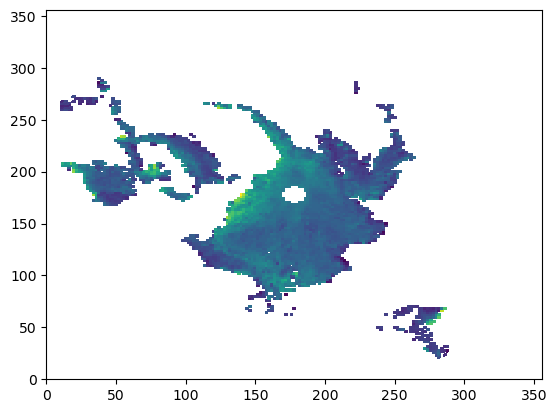

In [7]:
plt.pcolor(snow_201903[0])

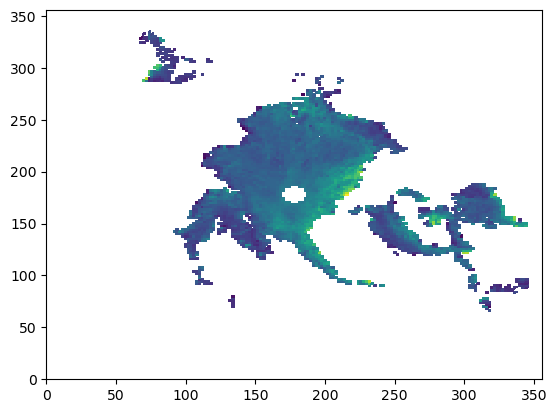

In [8]:
plt.pcolor(np.flip(snow_201903[0]))

In [9]:
def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [10]:
x_data, y_data = lonlat_to_xy(np.array(lon_data), np.asarray(lat_data), 'n', inverse = False)

In [11]:
ease_lats = np.load('/home/erb/masterproject/MSCI_project/new_lat_25km.npy')
ease_lons = np.load('/home/erb/masterproject/MSCI_project/new_lon_25km.npy')

# convert into x,y:
ease_x, ease_y = lonlat_to_xy(ease_lons,ease_lats,hemisphere='n')



In [12]:
# Interpolation des données 3D sur la grille 2D
snow_data_EASE = []
for i in range(len(snow_data)):
    EASE = griddata((x_data.ravel(), y_data.ravel()), snow_data[i].ravel(), (ease_x.ravel(), ease_y.ravel()), method='nearest')
    EASE = EASE.reshape(360, 360)
    snow_data_EASE.append(EASE)


In [13]:
snow_data_EASE = []
EASE = griddata((x_data.ravel(), y_data.ravel()), snow_201903[0].ravel(), (ease_x.ravel(), ease_y.ravel()), method='nearest')
EASE = EASE.reshape(360, 360)
snow_data_EASE.append(EASE)


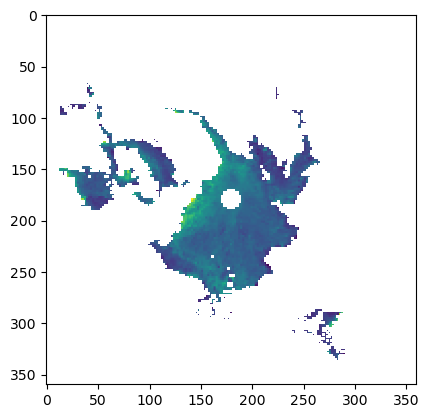

In [14]:
plt.imshow(snow_data_EASE[0])

In [15]:
snow_201903_EASE2=snow_data_EASE[0].reshape(360,360)

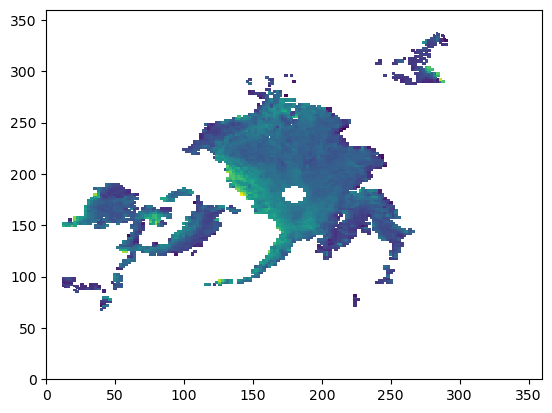

In [16]:
plt.pcolor(snow_201903_EASE2)

In [17]:
# Save fig
date = ['201810', '201811', '201812', '201901', '201902', '201903', '201904']
#for i in range(len(snow_data_EASE)):
        #np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_' + date[i]+ '_EASE2_laku_UIT.npy', snow_data_EASE[i])

#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201810_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201811_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201812_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201901_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201902_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201903_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201904_EASE2)


In [18]:
filename = '/home/hds/DATA/AWI_SIT/SMOS_daily/2019/11/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20191109_20191115_r_v202_02_l4sit.nc'
AWISMOS = nc.Dataset(filename)

ease_lats = np.load('/home/erb/masterproject/MSCI_project/new_lat_25km.npy')
ease_lons = np.load('/home/erb/masterproject/MSCI_project/new_lon_25km.npy')

# convert into x,y:
ease_x, ease_y = lonlat_to_xy(ease_lons,ease_lats,hemisphere='n')

lon_AWISMOS = AWISMOS.variables['lon'][:]
lat_AWISMOS = AWISMOS.variables['lat'][:]
SIT_AWISMOS = AWISMOS.variables['analysis_sea_ice_thickness'][:]

In [19]:
SIT_AWISMOS.data[0]

array([[-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09],
       [-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09],
       [-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09],
       ...,
       [-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09],
       [-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09],
       [-2.14748365e+09, -2.14748365e+09, -2.14748365e+09, ...,
        -2.14748365e+09, -2.14748365e+09, -2.14748365e+09]])

In [20]:
lon_AWISMOS

masked_array(
  data=[[-135.      , -135.13324 , -135.2671  , ...,  135.2671  ,
          135.13324 ,  135.      ],
        [-134.86676 , -135.      , -135.13387 , ...,  135.13387 ,
          135.      ,  134.86676 ],
        [-134.7329  , -134.86613 , -135.      , ...,  135.      ,
          134.86613 ,  134.7329  ],
        ...,
        [ -45.267113,  -45.13387 ,  -45.      , ...,   45.      ,
           45.13387 ,   45.267113],
        [ -45.133247,  -45.      ,  -44.86613 , ...,   44.86613 ,
           45.      ,   45.133247],
        [ -45.      ,  -44.866753,  -44.732887, ...,   44.732887,
           44.866753,   45.      ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

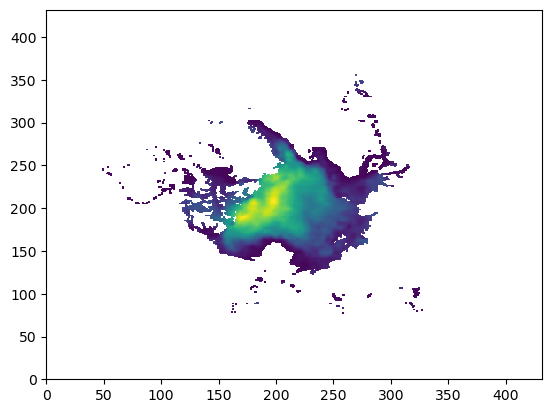

In [28]:
plt.pcolor(SIT_AWISMOS[0])

In [22]:

x_data, y_data = lonlat_to_xy(np.array(lon_AWISMOS), np.asarray(lat_AWISMOS), 'n', inverse = False)

snow_data_EASE = []

EASE = griddata((x_data.ravel(), y_data.ravel()), SIT_AWISMOS[0].ravel(), (ease_x.ravel(), ease_y.ravel()), method='cubic')
EASE = EASE.reshape(360, 360)
snow_data_EASE.append(EASE)

#interpolated_values = griddata((lon_AWISMOS.ravel(), lat_AWISMOS.ravel()), SIT_AWISMOS[0].ravel, (ease_lons.ravel(), ease_lats.ravel()), method='nearest')



In [23]:
lon_AWISMOS = AWISMOS.variables['lon'][:]
lat_AWISMOS = AWISMOS.variables['lat'][:]
SIT_AWISMOS = AWISMOS.variables['analysis_sea_ice_thickness']

In [24]:
lon_AWISMOS = lon_AWISMOS[36:396, 36:396]
lat_AWISMOS = lat_AWISMOS[34:398, 34:398]
SIT_AWISMOS2 = SIT_AWISMOS[0][36:396,36:396][::-1, :]


In [29]:
# Save fig
#for i in range(len(snow_data_EASE)):
        #np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_' + date[i]+ '_EASE2_laku_UIT.npy', snow_data_EASE[i])

np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/map_AWISMOS', SIT_AWISMOS2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201811_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201812_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201901_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201902_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201903_EASE2)
#np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy', snow_201904_EASE2)


NotImplementedError: MaskedArray.tofile() not implemented yet.